# step 0. 필요한 라이브러리 import

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import konlpy
import sentencepiece as spm
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

# step 1. 데이터 다운

네이버 영화리뷰 감정 분석 태스크 데이터셋 사용

In [2]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table(os.getenv('HOME')+'/aiffel/aiffel/AIFFEL_quest_rs/GoingDeeper/Gd01/ratings_train.txt')
test_data = pd.read_table(os.getenv('HOME')+'/aiffel/aiffel/AIFFEL_quest_rs/GoingDeeper/Gd01/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# step 2. 데이터 전처리 

결측치 처리

In [3]:
train_data.isnull().sum()

id          0
document    5
label       0
dtype: int64

In [4]:
train_data.dropna(inplace=True)

In [5]:
train_data.isnull().sum()

id          0
document    0
label       0
dtype: int64

In [6]:
test_data.isnull().sum()

id          0
document    3
label       0
dtype: int64

In [7]:
test_data.dropna(inplace=True)

In [8]:
test_data.isnull().sum()

id          0
document    0
label       0
dtype: int64

데이터 중복 확인

In [9]:
train_data['document'].duplicated().sum()

3813

In [10]:
train_data.drop_duplicates(subset = ['document'], inplace=True)

In [11]:
len(train_data)

146182

In [12]:
test_data['document'].duplicated().sum()

840

In [13]:
test_data.drop_duplicates(subset = ['document'], inplace=True)

In [14]:
len(test_data)

49157

데이터 분포 확인 - train_data

문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


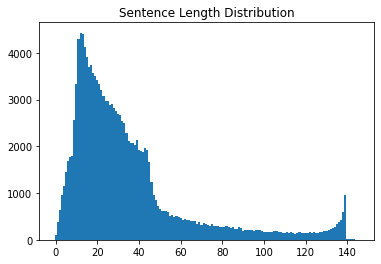

In [15]:
min_len = 999
max_len = 0
sum_len = 0

for sen in train_data['document']:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(train_data['document']))

sentence_length = np.zeros((max_len), dtype=int)

for sen in train_data['document']:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

데이터 분포 확인 - test_data

문장의 최단 길이: 1
문장의 최장 길이: 144
문장의 평균 길이: 35


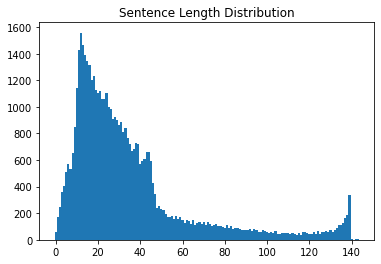

In [16]:
min_len = 999
max_len = 0
sum_len = 0

for sen in test_data['document']:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(test_data['document']))

sentence_length = np.zeros((max_len), dtype=int)

for sen in test_data['document']:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

문장의 길이의 이상치 데이터 확인 - train_data

In [17]:
# 문장 길이별 확인 해보는 함수
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

In [18]:
check_sentence_with_length(train_data['document'], 1)

아
잼
1
4
굿
짱
휴
.
음
?
ㅎ
ㅋ
즐
♥
굳
네
ㅇ
k
ㅠ
쒯
♬
토
O
똥
z
헐
삼
꽝
!
풉
ㅅ
왜
ㄴ
쉣
봐
뿌
ㅜ
♡
ㅁ
0
ㅉ
d
흥
乃
찜
귯
린
시
ㅗ
a
c
흠
웅
ㅣ
오
9
쩜
애
헝
쨩
f
움
ㄳ
업
헉
군
b
;
g
올
걍
허
-
쀍
로
ㄹ
ㅂ
갑
즛
킥
함
진
ㅡ
잠
곧
ㅍ
h
·
캬
ㅆ
,
풋
ㄱ
파
ㄷ
웩
꺅
욜
ㅄ
2
핡


In [19]:
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 4000을 초과하는 문장 길이를 추출합니다.
    if _sum > 4000:
        print("Outlier Index:", idx+1)

In [20]:
check_sentence_with_length(train_data['document'],14)

어설픈 전개 어이없는 결말
크리스마스하면 떠오르는영화
절대 보지마라 쓰레기 영화
베댓이 말을 아주 잘써놨네
정말 아름다운 영화 입니다
그저 한마디뿐 '알리시아'
또 보고 또 울.었.다..
딱히 재미는 없네요 킁;;
신선하네..,,..,,..
페이스 허거 같음ㅋㅋㅋㅋㅋ
전 정말 재미있게 봤습니다
그냥 레전드다 레전드!!!
짜가인가 이게뭐여..뭔..
굿 10자 이상 .가나다라
연기력에서 유혹하지 못한다
몇 안되는 재밌게 본 영화
역시 명작은 명작이다...
그냥 안보는게 이득 ...
중고생들의 마마추어 포르노
좋은 소재에 만족할 연출.
지들이 뭔데 대우를 까냐?
난이게 제일 재밌었는데..
영화보다 댓글이 더 재밌어
김민종 최고! 더 잘되시요
제 취향은 아니네요~~~~
크리스 터커 짱이삼! ㅋㅋ
대표적인 쓰레기 김치드라마
꽃 한송이 놓고 갑니다ㅋㅋ
아이들이 보기엔 좋을지도?
소희가 귀엽다 귀엽다 졸귀
왜 0점은 줄 수 없나요?
최강 전차부대 ..,,..
1점 주기도 아까운 쓰레기
급식충들이나 물고 빨 영화
이딴게 이렇게 평이 높다니
날고기와 코스요리의 공존.
록키는 무조건 10점줘야함
스타트랙보다100배재미있음
이거야말로 구제불능이군..
평점에 오류가 있는 영화다
휴.. 나 이거 왜봤지..
우아하다는 말에 공감 ㅎㅎ
영화보다나간적은처음..ㅠㅠ
호화 배우들 잡아 죽이기.
원작이 대단하긴 한가보다,
난 이거 되게 재밌네 ㅋㅋ
아 언제 4가 나오려나!!
좋아 아주 젛아 젛 아젛아
어른이 보기에도 잼남...
꼭 보세요 후회 안합니다?
윤하♥ 때문에 10점 ..
몇번째 보는지 모르겠다..
너희가 이 영화를 봤느뇨?
우아한 공포영화를 본거같다
거의 공감을 강요하는 영화
스토리가 무슨.. 막장이냐
와 ~ 완전 허접하다 ㅋㅋ
이건 그냥 닥치고 봐야된다
백인 여배우는 사랑한다..
잼남ㅋㅋㅋ시간가는줄몰랐네여
순진함을 가장한 억지영화.
유치해 너무 재미없어...
이건무슨 내용이 없어...
최고중에 하나였던 영화..
죄 짓고 못산다.. 참말로
너와나함께라면 우린 최고야
자각과 깨달음의 무

문장의 길이의 이상치 데이터 확인 - test_data

In [21]:
check_sentence_with_length(test_data['document'], 1)

.
굿
헐
d
굳
b
ㅗ
ㄱ
ㄹ
하
?
1
ㅋ
음
꿈
뻑
땡
ㅂ
좀
g
ㅇ
♥
짱
ㅉ
뷁
ㅜ
ㅄ
ㅣ
찜
헷
ㅎ
쨩
3
싫
0
우
악
쩝
f
오
쒯
h
풋
z
ㅈ
엿
잏
헉
흐
망
훗
와
ㅍ
‥
4
k
즐
꽉
호
·


Min_len 이하 데이터 제외

In [22]:
min_len = 1

# 길이 조건에 맞는 문장만 선택합니다.
train_data = train_data[train_data['document'].apply(lambda s: len(s) > min_len)]
test_data = test_data[test_data['document'].apply(lambda s: len(s) > min_len)]

# step 3. SentencePiece 모델 학습

단어 사전 생성을 위한 말뭉치 생성

In [23]:
len(train_data)

146081

In [24]:
len(test_data)

49097

In [25]:
corpus = []
for x in train_data['document']:
    corpus.append(x)
for x in test_data['document']:
    corpus.append(x)

In [26]:
len(corpus)

195178

SentencePiece 모델 학습

In [27]:
temp_file = os.getenv('HOME')+'/aiffel/aiffel/AIFFEL_quest_rs/GoingDeeper/Gd01/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in corpus:   
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/aiffel/AIFFEL_quest_rs/GoingDeeper/Gd01/korean-english-park.train.ko.temp --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/aiffel/AIFFEL_quest_rs/GoingDeeper/Gd01/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  har

-rw-r--r-- 1 root root 374807 Oct 11 01:46 korean_spm.model
-rw-r--r-- 1 root root 144146 Oct 11 01:46 korean_spm.vocab


In [28]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1398, 10, 382, 15, 1319, 10, 133, 17, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


# Step 4. Tokenizer 함수 작성

In [29]:
def sp_tokenize(s, corpus): 

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')

    return tensor, word_index, index_word

토큰화 진행

In [30]:
tensor, word_index, index_word = sp_tokenize(s, corpus)

# Step 5. 데이터셋 분리

In [31]:
x_train = tensor[:146081]

In [32]:
y_train = np.array(list(train_data['label']))

In [33]:
x_test = tensor[146081:]

In [34]:
y_test = np.array(list(test_data['label']))

validation set 구성

In [35]:
x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                  y_train, 
                                                  test_size=0.2, 
                                                  random_state=42)

# step 6. 모델 구성

Epoch 1/10
229/229 [==============================] - 188s 803ms/step - loss: 0.4274 - accuracy: 0.8029 - val_loss: 0.3538 - val_accuracy: 0.8450
Epoch 2/10
229/229 [==============================] - 183s 798ms/step - loss: 0.3176 - accuracy: 0.8666 - val_loss: 0.3345 - val_accuracy: 0.8553
Epoch 3/10
229/229 [==============================] - 183s 798ms/step - loss: 0.2816 - accuracy: 0.8818 - val_loss: 0.3339 - val_accuracy: 0.8560
Epoch 4/10
229/229 [==============================] - 184s 801ms/step - loss: 0.2528 - accuracy: 0.8936 - val_loss: 0.3431 - val_accuracy: 0.8534
Epoch 5/10
229/229 [==============================] - 183s 799ms/step - loss: 0.2322 - accuracy: 0.9013 - val_loss: 0.3634 - val_accuracy: 0.8520
Epoch 6/10
229/229 [==============================] - 182s 796ms/step - loss: 0.2132 - accuracy: 0.9100 - val_loss: 0.3832 - val_accuracy: 0.8532
Epoch 7/10
229/229 [==============================] - 182s 795ms/step - loss: 0.1959 - accuracy: 0.9171 - val_loss: 0.3992 -

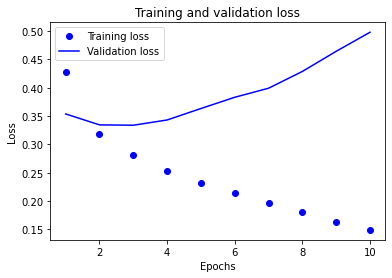

In [36]:
word_vector_dim = 256
gru_units = 64
dropout_rate = 0.5

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GRU(gru_units, recurrent_dropout=dropout_rate, return_sequences=True))
model.add(tf.keras.layers.GRU(gru_units, recurrent_dropout=dropout_rate))
model.add(tf.keras.layers.Dropout(dropout_rate))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

callbacks=[
    tf.keras.callbacks.ModelCheckpoint("sentencepiece_model.keras",
                                       
                                       save_best_only=True)
]

# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=callbacks)


model = tf.keras.models.load_model('sentencepiece_model.keras')

# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# step 7. KoNLPy 형태소 분석기를 사용한 모델과 성능 비교

KoNLPy 형태소 분석기 사용

In [37]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')

    return tensor, tokenizer

In [38]:
from konlpy.tag import Mecab
mecab = Mecab()

def mecab_split(sentence):
    return mecab.morphs(sentence)

mecab_corpus = []

for kor in corpus:
    mecab_corpus.append(mecab_split(kor))

토큰화 진행

In [39]:
mecab_tensor, mecab_tokenizer = tokenize(mecab_corpus)

데이터셋 분리

In [40]:
mecab_x_train = mecab_tensor[:146081]

In [41]:
mecab_y_train = np.array(list(train_data['label']))

In [42]:
mecab_x_test = mecab_tensor[146081:]

In [43]:
mecab_y_test = np.array(list(test_data['label']))

validation set 구성

In [44]:
mecab_x_train, mecab_x_val, mecab_y_train, mecab_y_val = train_test_split(mecab_x_train,
                                                                          mecab_y_train,
                                                                          test_size=0.2,
                                                                          random_state=42)

모델 구성 및 훈련

Epoch 1/10
229/229 [==============================] - 163s 699ms/step - loss: 0.4169 - accuracy: 0.8115 - val_loss: 0.3540 - val_accuracy: 0.8460
Epoch 2/10
229/229 [==============================] - 160s 698ms/step - loss: 0.3262 - accuracy: 0.8624 - val_loss: 0.3440 - val_accuracy: 0.8530
Epoch 3/10
229/229 [==============================] - 160s 697ms/step - loss: 0.2923 - accuracy: 0.8781 - val_loss: 0.3310 - val_accuracy: 0.8554
Epoch 4/10
229/229 [==============================] - 161s 703ms/step - loss: 0.2682 - accuracy: 0.8875 - val_loss: 0.3316 - val_accuracy: 0.8583
Epoch 5/10
229/229 [==============================] - 160s 701ms/step - loss: 0.2473 - accuracy: 0.8976 - val_loss: 0.3381 - val_accuracy: 0.8561
Epoch 6/10
229/229 [==============================] - 160s 699ms/step - loss: 0.2288 - accuracy: 0.9063 - val_loss: 0.3492 - val_accuracy: 0.8557
Epoch 7/10
229/229 [==============================] - 161s 703ms/step - loss: 0.2132 - accuracy: 0.9131 - val_loss: 0.3812 -

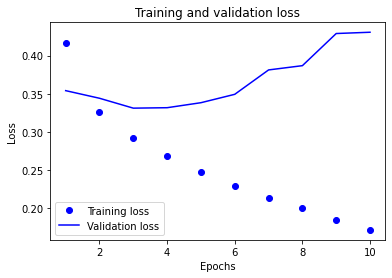

In [45]:
word_vector_dim = 256
gru_units = 64
dropout_rate = 0.5

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GRU(gru_units, recurrent_dropout=dropout_rate, return_sequences=True))
model.add(tf.keras.layers.GRU(gru_units, recurrent_dropout=dropout_rate))
model.add(tf.keras.layers.Dropout(dropout_rate))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

callbacks=[
    tf.keras.callbacks.ModelCheckpoint("mecab_model.keras",
                                       
                                       save_best_only=True)
]

# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(mecab_x_train,
                    mecab_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(mecab_x_val, mecab_y_val),
                    verbose=1,
                    callbacks=callbacks)


model = tf.keras.models.load_model('mecab_model.keras')

# 테스트셋을 통한 모델 평가
results = model.evaluate(mecab_x_test,  mecab_y_test, verbose=2)

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## KoNLPy VS SentencePiece

- KoNLPy
    - accuracy: 0.8560
- SentencePiece
    - accuracy: 0.8566
    
한국어는 보통 형태소 분석기가 좋은 성능을 냄

하지만 SentencePiece 또한 형태소 분석기와 차이가 없을 정도의 성능을 냄

왜 huggingface의 모델들이 SentencePiece 토큰화를 하는지 잘 알 수 있는 실험 결과였다.

# step 8. SentencePiece 모델의 성능 개선 여부 확인

위의 정의된 모델과 동일한 모델 구조 사용

In [46]:
# vocab_size 8000 -> 32000
temp_file = os.getenv('HOME')+'/aiffel/aiffel/AIFFEL_quest_rs/GoingDeeper/Gd01/full_vocab_size_korean-english-park.train.ko.temp'

with open(temp_file, 'w') as f:
    for row in corpus:   
        f.write(str(row) + '\n')

vocab_size=32000

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/aiffel/AIFFEL_quest_rs/GoingDeeper/Gd01/full_vocab_size_korean-english-park.train.ko.temp --model_prefix=korean_spm --vocab_size=32000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/aiffel/AIFFEL_quest_rs/GoingDeeper/Gd01/full_vocab_size_korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 32000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  tra

-rw-r--r-- 1 root root 863495 Oct 11 02:48 korean_spm.model
-rw-r--r-- 1 root root 654228 Oct 11 02:48 korean_spm.vocab


토큰화 진행

In [47]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

tensor, word_index, index_word = sp_tokenize(s, corpus)

데이터셋 분리

In [48]:
x_train = tensor[:146081]

In [49]:
y_train = np.array(list(train_data['label']))

In [50]:
x_test = tensor[146081:]

In [51]:
y_test = np.array(list(test_data['label']))

validation set 구성

In [52]:
x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                  y_train, 
                                                  test_size=0.2, 
                                                  random_state=42)

In [53]:
word_vector_dim = 256
gru_units = 64
dropout_rate = 0.5

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GRU(gru_units, recurrent_dropout=dropout_rate, return_sequences=True))
model.add(tf.keras.layers.GRU(gru_units, recurrent_dropout=dropout_rate))
model.add(tf.keras.layers.Dropout(dropout_rate))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=2  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

results = model.evaluate(x_test, y_test, verbose=2)

Epoch 1/2
229/229 [==============================] - 148s 633ms/step - loss: 0.4273 - accuracy: 0.7987 - val_loss: 0.3441 - val_accuracy: 0.8500
Epoch 2/2
229/229 [==============================] - 144s 629ms/step - loss: 0.2705 - accuracy: 0.8901 - val_loss: 0.3528 - val_accuracy: 0.8541
1535/1535 - 72s - loss: 0.3529 - accuracy: 0.8529


- vocab_size 8000 -> 32000
    - accuracy: 0.8566 -> 0.8529

---

In [54]:
# model_type unigram -> bpe
temp_file = os.getenv('HOME')+'/aiffel/aiffel/AIFFEL_quest_rs/GoingDeeper/Gd01/bpe_korean-english-park.train.ko.temp'

with open(temp_file, 'w') as f:
    for row in corpus:   
        f.write(str(row) + '\n')

vocab_size=8000

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={} --model_type={}'.format(temp_file, vocab_size, 'bpe')    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/aiffel/AIFFEL_quest_rs/GoingDeeper/Gd01/bpe_korean-english-park.train.ko.temp --model_prefix=korean_spm --vocab_size=8000 --model_type=bpe
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/aiffel/AIFFEL_quest_rs/GoingDeeper/Gd01/bpe_korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_

-rw-r--r-- 1 root root 370245 Oct 11 02:55 korean_spm.model
-rw-r--r-- 1 root root 115425 Oct 11 02:55 korean_spm.vocab


토큰화 진행

In [55]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

tensor, word_index, index_word = sp_tokenize(s, corpus)

데이터셋 분리

In [56]:
x_train = tensor[:146081]

In [57]:
y_train = np.array(list(train_data['label']))

In [58]:
x_test = tensor[146081:]

In [59]:
y_test = np.array(list(test_data['label']))

validation set 구성

In [60]:
x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                  y_train, 
                                                  test_size=0.2, 
                                                  random_state=42)

In [61]:
word_vector_dim = 256
gru_units = 64
dropout_rate = 0.5

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GRU(gru_units, recurrent_dropout=dropout_rate, return_sequences=True))
model.add(tf.keras.layers.GRU(gru_units, recurrent_dropout=dropout_rate))
model.add(tf.keras.layers.Dropout(dropout_rate))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=3  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

results = model.evaluate(x_test, y_test, verbose=2)

Epoch 1/3
229/229 [==============================] - 183s 786ms/step - loss: 0.4268 - accuracy: 0.8040 - val_loss: 0.3541 - val_accuracy: 0.8440
Epoch 2/3
229/229 [==============================] - 180s 786ms/step - loss: 0.3221 - accuracy: 0.8638 - val_loss: 0.3352 - val_accuracy: 0.8486
Epoch 3/3
229/229 [==============================] - 179s 782ms/step - loss: 0.2842 - accuracy: 0.8802 - val_loss: 0.3399 - val_accuracy: 0.8523
1535/1535 - 90s - loss: 0.3379 - accuracy: 0.8558


- model_type unigram -> bpe
    - accuracy: 0.8566 -> 0.8558

---

In [63]:
# model_type unigram -> bpe, vocab_size 8000 -> 32000
temp_file = os.getenv('HOME')+'/aiffel/aiffel/AIFFEL_quest_rs/GoingDeeper/Gd01/bpe_vocab_size_32000_korean-english-park.train.ko.temp'

with open(temp_file, 'w') as f:
    for row in corpus:   
        f.write(str(row) + '\n')

vocab_size=32000

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={} --model_type={}'.format(temp_file, vocab_size, 'bpe')    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

-rw-r--r-- 1 root root 839707 Oct 11 03:44 korean_spm.model
-rw-r--r-- 1 root root 558865 Oct 11 03:44 korean_spm.vocab


토큰화 진행

In [64]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

tensor, word_index, index_word = sp_tokenize(s, corpus)

데이터셋 분리

In [65]:
x_train = tensor[:146081]

In [66]:
y_train = np.array(list(train_data['label']))

In [67]:
x_test = tensor[146081:]

In [68]:
y_test = np.array(list(test_data['label']))

validation set 구성

In [69]:
x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                  y_train, 
                                                  test_size=0.2, 
                                                  random_state=42)

In [70]:
word_vector_dim = 256
gru_units = 64
dropout_rate = 0.5

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GRU(gru_units, recurrent_dropout=dropout_rate, return_sequences=True))
model.add(tf.keras.layers.GRU(gru_units, recurrent_dropout=dropout_rate))
model.add(tf.keras.layers.Dropout(dropout_rate))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=2  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

results = model.evaluate(x_test, y_test, verbose=2)

Epoch 1/2
229/229 [==============================] - 160s 687ms/step - loss: 0.4305 - accuracy: 0.7986 - val_loss: 0.3444 - val_accuracy: 0.8511
Epoch 2/2
229/229 [==============================] - 157s 684ms/step - loss: 0.2701 - accuracy: 0.8908 - val_loss: 0.3447 - val_accuracy: 0.8534
1535/1535 - 78s - loss: 0.3481 - accuracy: 0.8524


- model_type unigram -> bpe, vocab_size 8000 -> 32000
    - accuracy: 0.8566 -> 0.8524

# 회고

- 형태소 분석기와 SentencePiece의 성능을 비교했을 때 성능 차이가 거의 없는 것을 확인할 수 있었다. 
    - 범용성이 좋은 SentencePiece을 앞으로 자주 사용할 거 같은 느낌이 든다!!

- SentencePiece 모델의 성능 개선을 위해 3개 정도의 실험을 진행했으나 오차 범위로 생각될 정도의 결과가 나왔다. 
    - 기본으로 설정되어 있는 model_type = unigram, vocab_size = 8000이 제일 좋은 거 같다.